# Non linear Fit One profile in All U,G,R,I Z band

- author  :Sylvie Dagoret-Campagne
- affiliaiton : IJCLab/IN2P3/CNRS
- creation date : April 26th 2020
- update date :


Study the relative atmosphere relative to an ideal profile in **libradtran/info_verbose/RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.OUT**
- no aerosol
- pwv =4 mm
- ozone = 3000 DU
- No extinction coefficient
- airmass = 1


Fit components:

- h2o,
- o2,
- o3


The non-linear fit for the aerosols is added


In [176]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import pandas as pd
import os
import sys
%matplotlib inline

In [177]:
from astropy.io import fits

In [178]:
from pprint import pprint # we use this to pretty print some stuff later

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

from iminuit import minimize  # has same interface as scipy.optimize.minimize

In [179]:
from datetime import datetime,date
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [180]:
#to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [181]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

In [182]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Configuration

## Filter boudaries

In [183]:
file_wavelengthbins="data/WaveLengthBins.csv"

In [184]:
df=pd.read_csv(file_wavelengthbins,index_col=0)

In [185]:
df

,band,wl_aver,wl_wdth,wl_min,wl_max
0,u,356.0,78.0,317.0,395.0
1,g,472.0,154.0,395.0,549.0
2,r,619.0,140.0,549.0,689.0
3,i,754.0,130.0,689.0,819.0
4,z,870.5,103.0,819.0,922.0
5,y,1010.0,176.0,922.0,1098.0


In [186]:
NBFILTER=len(df)

In [187]:
FILTER_NAME=df["band"].values
WL_MIN=df["wl_min"].values
WL_MAX=df["wl_max"].values
WL_WIDTH=df["wl_wdth"].values

## Absorption pattern

In [188]:
file_abspattern="data/absorption_pattern.csv"

In [189]:
df_atm=pd.read_csv(file_abspattern,index_col=0)

In [190]:
print(df_atm.columns.tolist())

['wl', 'o2_10', 'o2_11', 'o2_12', 'o2_13', 'o2_14', 'o2_15', 'o2_16', 'o2_17', 'o2_18', 'o2_19', 'o2_20', 'o2_21', 'o2_22', 'o2_23', 'o2_24', 'o2_25', 'o3_10', 'o3_11', 'o3_12', 'o3_13', 'o3_14', 'o3_15', 'o3_16', 'o3_17', 'o3_18', 'o3_19', 'o3_20', 'o3_21', 'o3_22', 'o3_23', 'o3_24', 'o3_25', 'h2o_10', 'h2o_11', 'h2o_12', 'h2o_13', 'h2o_14', 'h2o_15', 'h2o_16', 'h2o_17', 'h2o_18', 'h2o_19', 'h2o_20', 'h2o_21', 'h2o_22', 'h2o_23', 'h2o_24', 'h2o_25', 'no2_10', 'no2_11', 'no2_12', 'no2_13', 'no2_14', 'no2_15', 'no2_16', 'no2_17', 'no2_18', 'no2_19', 'no2_20', 'no2_21', 'no2_22', 'no2_23', 'no2_24', 'no2_25']


In [191]:
rootfilename=file_abspattern.split(".")[0]

In [192]:
all_df_atm=[]
for iband in np.arange(NBFILTER):
    filename=rootfilename+"_"+FILTER_NAME[iband]+".csv"
    print("====================",filename,"=======================")
    df=pd.read_csv(filename,index_col=0)
    #df=df.reset_index(drop=True)
    all_df_atm.append(df)

==================== data/absorption_pattern_u.csv =======================
==================== data/absorption_pattern_g.csv =======================
==================== data/absorption_pattern_r.csv =======================
==================== data/absorption_pattern_i.csv =======================
==================== data/absorption_pattern_z.csv =======================
==================== data/absorption_pattern_y.csv =======================


## Atmospheric data

In [193]:
DATADIR="../data/atm"

## Reference atmosphere

In [194]:
data=np.loadtxt("data/RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.OUT")
wl0=data[:,0]
transm0=data[:,1]

## Decoding function

In [195]:
def GetAtmosphericProfiles(dir,wl_ref,transm_ref):
    """
    """
    atmospheric_basename_files=os.listdir(dir)
    inputfile=os.path.join(DATADIR,atmospheric_basename_files[0])
    
    idx=0
    # containers
    all_data=[]
    all_hdr=[]
    all_wl=[]
    
    # loop on files
    for file in atmospheric_basename_files:
        inputfile=os.path.join(DATADIR,file)
        hdu = fits.open(inputfile)
        all_hdr.append(hdu[0].header)
        all_data.append(hdu[0].data[1:,:])
        all_wl.append(hdu[0].data[0,:])
        idx+=1
        hdu.close()
        
    data=np.vstack(all_data)
    hdr=all_hdr[0]
    
    #decode index from header
    NbAtmSimul=hdr['NBATMSIM']
    idx_out_num=hdr['ID_NUM']
    idx_out_year=hdr['ID_YEAR']
    idx_out_am=hdr['ID_AM']
    idx_out_vaod=hdr['ID_VAOD']
    idx_out_pwv=hdr['ID_PWV']
    idx_out_o3=hdr['ID_O3']
    idx_out_cld=hdr['ID_CLD']
    idx_out_res=hdr['ID_RES']
    
    vaod=data[1:,idx_out_vaod] # vertical aerosol depth
    pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
    o3=data[1:,idx_out_o3]     # ozone
    cld=data[1:,idx_out_cld]   # clouds (not used)
    
    
    # Extract wavelength Wavelength
    wl=all_wl[0][idx_out_res:]
    transm=data[:,idx_out_res:]
    
    if len(wl)==len(wl_ref) and wl[0]== wl_ref[0]:
        transm/=transm_ref
    else:
        print("error reference does not match")
        
    
    return wl,transm,vaod,pwv,o3,cld
     

# Open all atmospheric files

In [196]:
wl,transm,vaod,pwv,o3,cld=GetAtmosphericProfiles(DATADIR,wl0,transm0)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


In [197]:
NBSIM=transm.shape[0]

# Distribute the relative transmission in the different filters

In [198]:
all_wl_filt=[]
all_transm_filt=[]
for iband in np.arange(NBFILTER):
    wl_indexes=np.where(np.logical_and(wl>=WL_MIN[iband],wl<=WL_MAX[iband]))[0]
    wl_filt=wl[wl_indexes]
    transm_filt=transm[:,wl_indexes]
    all_wl_filt.append(wl_filt)
    all_transm_filt.append(transm_filt)

# Preview

In [199]:
IDX_SIM=20

In [200]:
# bins in wevelength
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSIM)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSIM), alpha=1)

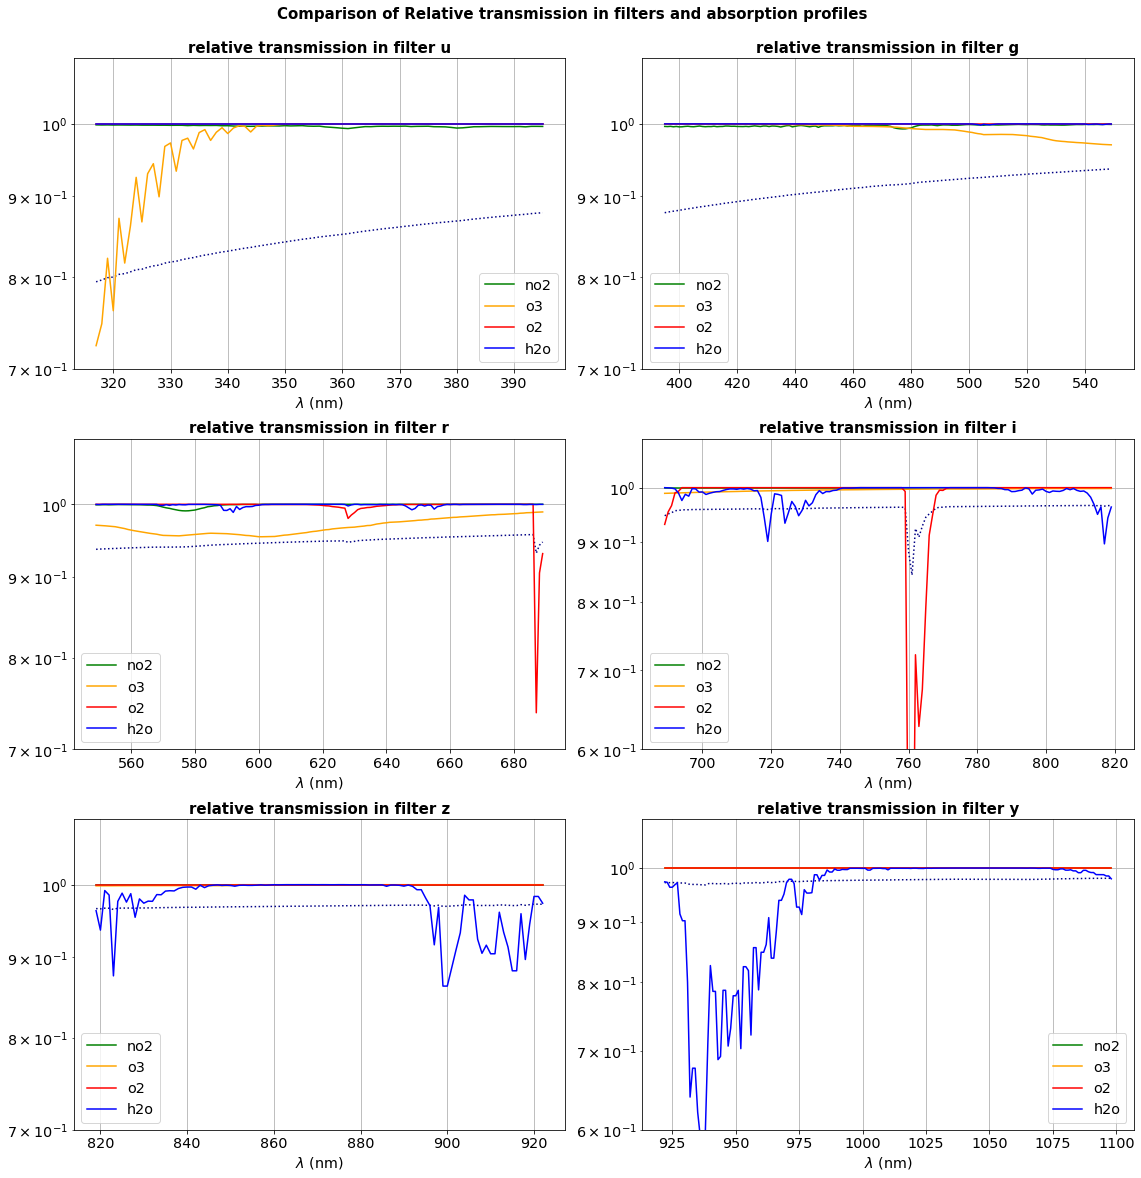

In [201]:
plt.figure(figsize=(16,16))
# loop on filter
for iband in np.arange(NBFILTER):
   
    wl=all_wl_filt[iband]
    transm=all_transm_filt[iband] 
    
    plt.subplot(3,2,iband+1)  
    # loop on simulation
    for idx in np.arange(IDX_SIM,IDX_SIM+1):
        
        colorVal=scalarMap.to_rgba(idx, alpha=1)
        plt.plot(wl,transm[idx,:],":",color=colorVal)
        
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["no2_12"],"g-",label="no2")
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["o3_12"],"-",color="orange",label="o3")
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["o2_12"],"r-",label="o2")
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["h2o_12"],"b-",label="h2o")
            
    plt.grid(True)
    if iband<=2:
        plt.ylim(0.7,1.1)
    elif iband<=3:
        plt.ylim(0.6,1.1)
    elif iband<=4:
        plt.ylim(0.7,1.1)
    else:
        plt.ylim(0.6,1.1)
        
    plt.yscale("log")
    plt.xlabel("$\lambda$ (nm)")
    plt.legend(loc="best")
    title="relative transmission in filter {}".format(FILTER_NAME[iband])
    plt.title(title,fontweight="bold",fontsize=15)
plt.suptitle("Comparison of Relative transmission in filters and absorption profiles",fontweight="bold",fontsize=15,y=1.02)
figname=string_date+"_RelativeTransmissionFiltersAndAbsPatterns.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()  

# Fit

## Definition of the parameter structure

- params is defined as follow

### First components

- h2o
- o2
- o3

#### Continuous background

- a0 : grey term in Y
- a1 : slope in Z band
- a2 : slope in I band
- a3 : slope in R band
- a4 : slope in G band
- a5 : slope in U band


- b1 : second order in Z band
- b2 : second order in I band
- b3 : second order in R band
- b4 : second order in G band
- b5 : second order in U band

In [202]:
PARAMS_NAMES = ["h2o","o2","o3","a0","a1","a2","a3","a4","a5","b1","b2","b3","b4","b5"]
NPARAMS =len(PARAMS_NAMES )

#### Inititalisation 

In [203]:
PARAMS0_   = np.array([1,1,1,0.1,0,0,0,0,0,0,0,0,0,0])
NBPARAMS = len(PARAMS0_)
PARAMSERR_ = np.ones(NBPARAMS) *0.0001

## Flags

In [204]:
FLAG_FIT_U = True
FLAG_FIT_G = True
FLAG_FIT_R = True
FLAG_FIT_I = True
FLAG_FIT_Z = True
FLAG_FIT_Y = True

In [205]:
FLAGS_FIT_SEL = np.array([FLAG_FIT_Y,FLAG_FIT_Z,FLAG_FIT_I,FLAG_FIT_R,FLAG_FIT_G,FLAG_FIT_U])
FLAGS_FIT_NUM = np.array([5,4,3,2,1,0])

## Global variables

In [206]:
IBAND_     = 5
DATA_      = all_transm_filt[iband][IDX_SIM,:]
WL_        = all_wl_filt[iband]
PATTERNS_  = [all_df_atm[iband]["h2o_12"].values , all_df_atm[iband]["o2_12"].values , all_df_atm[iband]["o3_12"].values] # only one pattern

## Fit function

In [207]:
def SetGlobals(iband):
    """
    Defines global variables used by fit function:
    
    DATA_     :  transmission ratio data
    PATTERNS_ :  array of absorption pattern
    WL_       :  wavelength
    
    """
    global IBAND_       # Current band 
    global DATA_        # transmission ratio data
    global PATTERNS_    # array of absorption pattern
    global WL_          # wavelength
    
    IBAND_     = iband
    DATA_      = all_transm_filt[iband][IDX_SIM,:]
    WL_        = all_wl_filt[iband]
    PATTERNS_  = [all_df_atm[iband]["h2o_12"].values , all_df_atm[iband]["o2_12"].values , all_df_atm[iband]["o3_12"].values] # only one pattern


In [208]:
def ContinuousComponent(x,cparams):
    """
    ContinuousComponent(x,iband,cparams):
    
    input argument :
     x     : wavelength, can be a numpy array
    
    """
    
    a0=cparams[0]  # grey term
    a1=cparams[1]  # slope in Z
    a2=cparams[2]  # slope in I
    a3=cparams[3]  # slope in R
    a4=cparams[4]  # slope in G
    a5=cparams[5]  # slope in U
    
    b1=cparams[6]  # slope in Z
    b2=cparams[7]  # slope in I
    b3=cparams[8]  # slope in R
    b4=cparams[9]  # slope in G
    b5=cparams[10]  # slope in U
    
    x0=WL_MIN[0]   # lower bound in U
    x1=WL_MIN[1]   # lower bound in G
    x2=WL_MIN[2]   # lower bound in R
    x3=WL_MIN[3]   # lower bound in I
    x4=WL_MIN[4]   # lower bound in Z
    x5=WL_MIN[5]   # lower bound in Y
    x6=WL_MAX[5]   # upper bound in Y
    
    w0=x6-x5       # width of Y
    w1=x5-x4       # width of Z 
    w2=x4-x3       # width of I
    w3=x3-x2       # width of R
    w4=x2-x1       # width of G
    w5=x1-x0       # width of U
    
    
    if   IBAND_ == 5 :    # Y band
        y = a0 * np.ones(len(x))    
    elif IBAND_ == 4 : # Z band
        y = a0 + a1*(x-x5) + b1*(x-x5)**2
    elif IBAND_ == 3 : # I band
        y = a0 - a1*w1 +b1*w1**2 + a2*(x-x4) +b2*(x-x4)**2
    elif IBAND_ == 2 : # R band
        y = a0 - a1*w1 +b1*w1**2 - a2*w2 + b2*w2**2 + a3*(x-x3) + b3*(x-x3)**2
    elif IBAND_ == 1 : # R band
        y = a0 - a1*w1 +b1*w1**2 - a2*w2 + b2*w2**2 - a3*w3 + b3*w3**2 + a4*(x-x2) + b4*(x-x2)**2
    elif IBAND_ == 0 : # R band
        y = a0 - a1*w1 +b1*w1**2 - a2*w2 + b2*w2**2 - a3*w3 + b3*w3**2 - a4*w4 + b4*w4**2 + a5*(x-x1) + b5*(x-x1)**2
    
    return y

In [209]:
def ModelInBand(params):
    """
    """
    NBPATTERNS=len(PATTERNS_)    # number of absorption patterns in the model
    CPARAMS=params[NBPATTERNS:]  # parameters for the continuous model
    
    
    #print("ModelInBand :: NBPATTERNS = {}".format(NBPATTERNS))
    #print("ModelInBand :: CPARAMS = ",CPARAMS)
    
    # create the model, one value per wavelength in the band (numpy array)
    # add the continuous model    
    model   = ContinuousComponent(WL_,CPARAMS)
    
    # add component one by one
    for idx_component in np.arange(NBPATTERNS):
        model  = model + params[idx_component]*PATTERNS_[idx_component]
         
    return model  

In [210]:
def Chi2OneFiltAbsPatternAndGrey_np(params):
    """
    Chi2(data,patterns,params) compute the chi2 in one band
    
    The format is complient with iMinuit
    
    External DATA_,PATTERNS_
    
    
    - data: one numpy array of data (ratio for each wavelength bin)
    - patterns : list of arrays of absorption patterns
    - params : array of values one grey plus one factor for each of the pattern 
    
    The data and the patterns much match in size
    
    Compute the chi2: 
    
    Note no error is probided at the moment
    
    """
    
    global DATA_
     
    model = ModelInBand(params)
    
    assert len(DATA_) == len(model)
   
    diff=DATA_- model
        
    diff2=diff**2    # compute the difference 
    chi2=diff2.sum() # compute the sum
    
    return chi2
    

# Fit in Three bands

## Fit in Y filter : H2O and Grey scale

In [211]:
iband=5

In [212]:
IBAND_     = 5
WL_        = all_wl_filt[IBAND_]
DATA_      = all_transm_filt[IBAND_][IDX_SIM,:]
PATTERNS_  = [all_df_atm[IBAND_]["h2o_12"].values] # only one pattern
PARAMS0_   = np.array([1,0.1,0,0,0,0,0,0,0,0,0,0])
PARAMSERR_ = np.ones(PARAMS0_.shape)*0.0001
FIXPARAMS_ = (False,False,True,True,True,True,True,True,True,True,True,True)

In [213]:
m = Minuit.from_array_func(Chi2OneFiltAbsPatternAndGrey_np, PARAMS0_, error=PARAMSERR_, fix=FIXPARAMS_,
                           name = ("h2o", "a0","a1","a2","a3","a4","a5","b1","b2","b3","b4","b5"),errordef=1)
m.get_param_states()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | h2o  |   1.000   |   0.000   |            |            |         |         |       |
| 1 | a0   | 1.000E-1  | 0.001E-1  |            |            |         |         |       |
| 2 | a1   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 3 | a2   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 4 | a3   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 5 | a4   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 6 | a5   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 7 | b1   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 8 | b2   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 9 | b3   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 10| b4   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 11| b5   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
------------------------------------------------------------------------------------------

In [214]:
PARAMS0_

array([1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [215]:
m.migrad()

------------------------------------------------------------------
| FCN = 0.0004945               |      Ncalls=35 (35 total)      |
| EDM = 3.08E-22 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | h2o  |   0.029   |   0.746   |            |            |         |         |       |
| 1 | a0   |    0.9    |    0.7    |            |            |         |         |       |
| 2 | a1   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 3 | a2   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 4 | a3   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 5 | a4   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 6 | a5   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 7 | b1   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 8 | b2   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 9 | b3   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 10| b4   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
| 11| b5   |  0.000E1  |  0.000E1  |            |            |         |         |  yes  |
------------------------------------------------------------------------------------------

In [216]:
#minimize(Chi2OneFiltAbsPatternAndGrey_np, PARAMS0_)

In [217]:
h2o_fit=m.values[0]
grey_fit=m.values[1]
h2o_fit_err=m.errors[0]
grey_fit_err=m.errors[1]

In [218]:
wl=all_wl_filt[IBAND_]
transm=all_transm_filt[IBAND_][IDX_SIM,:]

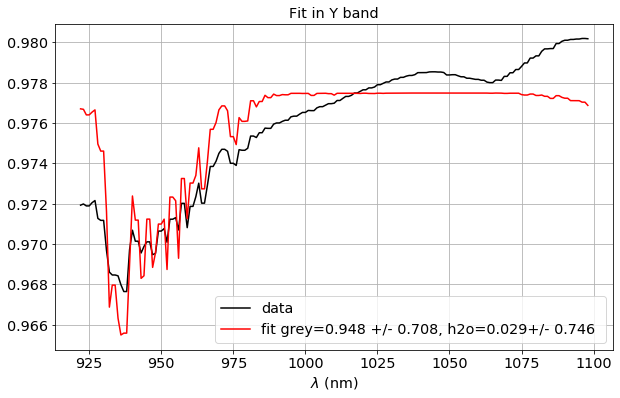

In [219]:
plt.title("Fit in Y band")
plt.plot(wl,transm,"k-",label="data")
label="fit grey={:1.3f} +/- {:1.3f}, h2o={:1.3f}+/- {:1.3f} ".format(grey_fit,grey_fit_err,h2o_fit,h2o_fit_err)
plt.plot(wl,grey_fit+h2o_fit*PATTERNS_[0],'r-',label=label)
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

## Fit in all bands

In [220]:
h2o_0  = h2o_fit
o2_0   = 1.
o3_0   = 1.
a0_0   = grey_fit

In [221]:
DATA_      = all_transm_filt[iband][IDX_SIM,:]
PATTERNS_  = [all_df_atm[iband]["h2o_12"].values , all_df_atm[iband]["o2_12"].values, all_df_atm[iband]["o3_12"].values ] # only one pattern
PARAMS0_   = np.array([h2o_0,o2_0,o3_0, a0_0,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.])
PARAMSERR_ = np.ones(PARAMS0_.shape)*0.00001

In [222]:
FLAG_FIT_U = True
FLAG_FIT_G = True
FLAG_FIT_R = True
FLAG_FIT_I = True
FLAG_FIT_Z = True
FLAG_FIT_Y = True

In [223]:
FLAGS_FIT_SEL = np.array([FLAG_FIT_Y,FLAG_FIT_Z,FLAG_FIT_I,FLAG_FIT_R,FLAG_FIT_G,FLAG_FIT_U])
FLAGS_FIT_NUM = np.array([5,4,3,2,1,0])

In [224]:
def Chi2ManyFiltAbsPatternAndGrey_np(params):
    """
    Chi2(data,patterns,params) compute the chi2 in one band
    
    The format is complient with iMinuit
    
    External DATA_,PATTERNS_
    
    
    - data: one numpy array of data (ratio for each wavelength bin)
    - patterns : list of arrays of absorption patterns
    - params : array of values one grey plus one factor for each of the pattern 
    
    The data and the patterns much match in size
    
    Compute the chi2: 
    
    Note no error is probided at the moment
    
    """
    # first band
    
    
    global DATA_
    global PATTERNS_
    
    
    chi2=0
    
    # loop on bands starting by Y only for validated 
    for idx,iband in np.ndenumerate(FLAGS_FIT_NUM):
        
        if FLAGS_FIT_SEL[idx[0]]:  
            
            SetGlobals(iband)            
            chi2+=Chi2OneFiltAbsPatternAndGrey_np(params)     # Compute for that band
            
    return chi2
    

In [225]:
m = Minuit.from_array_func(Chi2ManyFiltAbsPatternAndGrey_np, PARAMS0_, error=PARAMSERR_, name = ("h2o","o2","o3","a0","a1","a2","a3","a4","a5","b1","b2","b3","b4","b5" ),errordef=1)
m.get_param_states()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | h2o  | 2.943E-2  | 0.001E-2  |            |            |         |         |       |
| 1 | o2   |   1.000   |   0.000   |            |            |         |         |       |
| 2 | o3   |   1.000   |   0.000   |            |            |         |         |       |
| 3 | a0   |   0.948   |   0.000   |            |            |         |         |       |
| 4 | a1   |  0.000E1  |  0.000E1  |            |            |         |         |       |
| 5 | a2   |  0.000E1  |  0.000E1  |            |            |         |         |       |
| 6 | a3   |  0.000E1  |  0.000E1  |            |            |         |         |       |
| 7 | a4   |  0.000E1  |  0.000E1  |            |            |         |         |       |
| 8 | a5   |  0.000E1  |  0.000E1  |            |            |         |         |       |
| 9 | b1   |  0.000E1  |  0.000E1  |            |            |         |         |       |
| 10| b2   |  0.000E1  |  0.000E1  |            |            |         |         |       |
| 11| b3   |  0.000E1  |  0.000E1  |            |            |         |         |       |
| 12| b4   |  0.000E1  |  0.000E1  |            |            |         |         |       |
| 13| b5   |  0.000E1  |  0.000E1  |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [226]:
m.migrad()

------------------------------------------------------------------
| FCN = 0.001779                |     Ncalls=552 (552 total)     |
| EDM = 1.22E-14 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | h2o  |   0.029   |   0.719   |            |            |         |         |       |
| 1 | o2   |   0.15    |   0.95    |            |            |         |         |       |
| 2 | o3   |   0.029   |   3.531   |            |            |         |         |       |
| 3 | a0   |    0.8    |    3.7    |            |            |         |         |       |
| 4 | a1   | 0.022E-2  | 0.655E-2  |            |            |         |         |       |
| 5 | a2   | 0.008E-2  | 0.688E-2  |            |            |         |         |       |
| 6 | a3   | 0.012E-2  | 0.642E-2  |            |            |         |         |       |
| 7 | a4   | 0.020E-2  | 0.595E-2  |            |            |         |         |       |
| 8 | a5   |  0.06E-2  |  1.75E-2  |            |            |         |         |       |
| 9 | b1   | 0.012E-4  | 0.703E-4  |            |            |         |         |       |
| 10| b2   | 0.000E-4  | 0.504E-4  |            |            |         |         |       |
| 11| b3   | -0.002E-4 |  0.424E-4 |            |            |         |         |       |
| 12| b4   | -0.011E-4 |  0.370E-4 |            |            |         |         |       |
| 13| b5   | -0.04E-4  |  2.96E-4  |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [227]:
h2o_fit=m.values[0]
o2_fit=m.values[1]
o3_fit=m.values[2]
grey_fit=m.values[3]

h2o_fit_err=m.errors[0]
o2_fit_err=m.errors[1]
o3_fit_err=m.errors[2]
grey_fit_err=m.errors[3]

### Get result

In [228]:
params=m.np_values()
paramserr=m.np_errors()

## Plot

Text(0.5, 1.02, 'fit in R,I,Z,Y band h2o=0.029+/- 0.719 , o2=0.152+/- 0.950 , o3=0.029+/- 3.531 ')

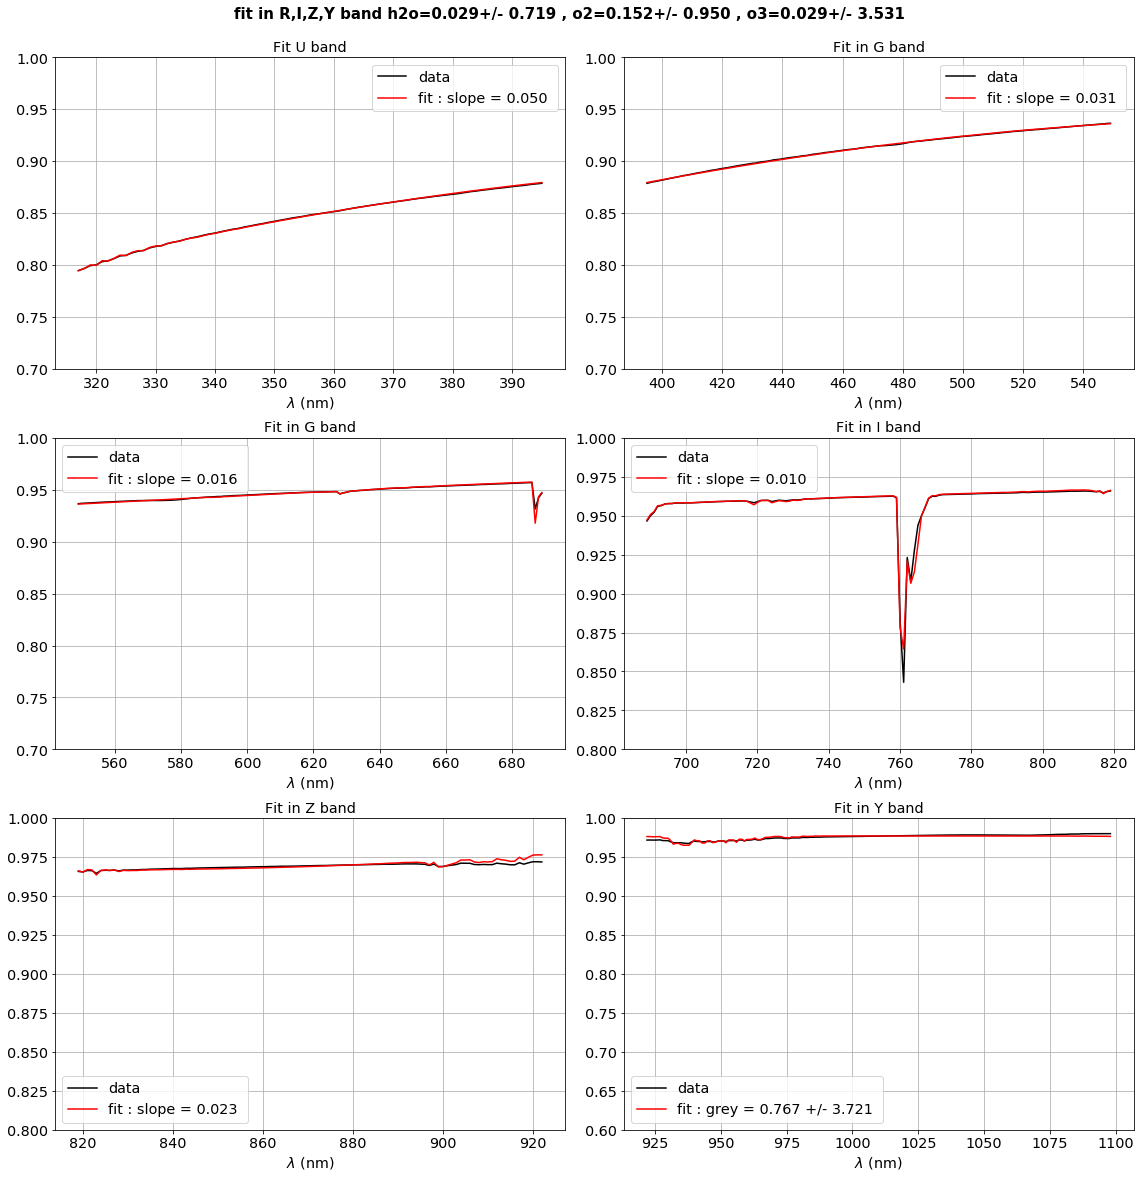

In [229]:


plt.figure(figsize=(16,16))
#---------------------------------


#----------------------------------

plt.subplot(3,2,1)
iband=0
SetGlobals(iband)
MODELS = ModelInBand(params)
label_fit="fit : slope = {:3.3f} ".format(params[8]*WL_WIDTH[0])

plt.title("Fit U band")
plt.plot(WL_,DATA_,"k-",label="data")
plt.plot(WL_,MODELS,'r-',label=label_fit)
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)

#-----------------




#----------------------------------

plt.subplot(3,2,2)
iband=1

SetGlobals(iband)
MODELS = ModelInBand(params)
label_fit="fit : slope = {:3.3f} ".format(params[7]*WL_WIDTH[1])

plt.title("Fit in G band")
plt.plot(WL_,DATA_,"k-",label="data")
plt.plot(WL_,MODELS,'r-',label=label_fit)
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)

#-----------------



#----------------------------------

plt.subplot(3,2,3)
iband=2

SetGlobals(iband)
MODELS = ModelInBand(params)
label_fit="fit : slope = {:3.3f} ".format(params[6]*WL_WIDTH[2])


plt.title("Fit in G band")
plt.plot(WL_,DATA_,"k-",label="data")
plt.plot(WL_,MODELS,"r-",label=label_fit)
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)

#-----------------


plt.subplot(3,2,4)
iband=3

SetGlobals(iband)
MODELS = ModelInBand(params)
label_fit="fit : slope = {:3.3f} ".format(params[5]*WL_WIDTH[3])


plt.title("Fit in I band")
plt.plot(WL_,DATA_,"k-",label="data")
plt.plot(WL_,MODELS,'r-',label=label_fit)
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)

#------------------

plt.subplot(3,2,5)
iband=4

SetGlobals(iband)
MODELS = ModelInBand(params)
label_fit="fit : slope = {:3.3f} ".format(params[4]*WL_WIDTH[4])


plt.title("Fit in Z band")
plt.plot(WL_,DATA_,"k-",label="data")
plt.plot(WL_,MODELS,'r-',label=label_fit)
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)
    
#-----------------------    

plt.subplot(3,2,6)
iband=5

SetGlobals(iband)
MODELS = ModelInBand(params)
label_fit="fit : grey = {:3.3f} +/- {:3.3f} ".format(grey_fit,grey_fit_err)

plt.title("Fit in Y band")
plt.plot(WL_,DATA_,"k-",label="data")
plt.plot(WL_,MODELS,'r-',label=label_fit)
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)
    
#----------------------------    
plt.tight_layout()


suptitle="fit in R,I,Z,Y band h2o={:1.3f}+/- {:1.3f} , o2={:1.3f}+/- {:1.3f} , o3={:1.3f}+/- {:1.3f} ".format(h2o_fit,h2o_fit_err,o2_fit,o2_fit_err,o3_fit,o3_fit_err)
plt.suptitle(suptitle,y=1.02,fontweight="bold",fontsize=15)

# Result

Text(0.5, 1.0, 'Atmospheric transmission - original (line), fitted (dotted)')

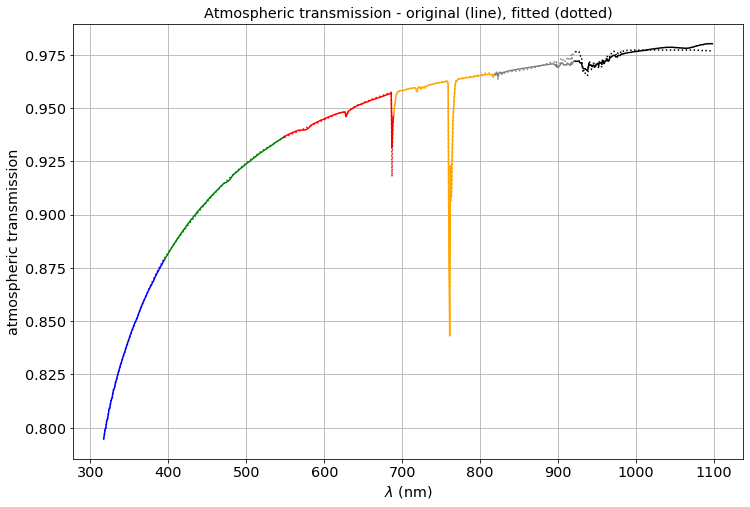

In [230]:
plt.figure(figsize=(12,8))
all_model_wl=[]
all_model_transmratio = []
all_data_transmratio = []
all_color = ["b","g","r","orange","grey","k"]
for iband in np.arange(NBFILTER):
     
    SetGlobals(iband)
    MODELS = ModelInBand(params)
    plt.plot(WL_,DATA_,"-",color=all_color[iband])
    plt.plot(WL_,MODELS,":",color=all_color[iband])
plt.grid()
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("atmospheric transmission")
plt.title("Atmospheric transmission - original (line), fitted (dotted)")